In [1]:
%cd ../../

/mnt/sda/otani/Experiments/eval-detection


In [2]:
from mim import test, download, get_model_info
from mim.utils import DEFAULT_CACHE_DIR
import os
import json
import mmcv
from mmcv.utils.config import Config
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import click
import time
import pdb
import tempfile

from src.extensions.dataset.coco_custom import CocoOtcDataset
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm
import glob
import pandas as pd
from tabulate import tabulate
import neptune.new as neptune
from neptune.new.types import File
from data.conf.model_cfg import MODEL_CFGS
from src.utils.neptune_utils import load_hparam_neptune
from mmdet.datasets import build_dataset, get_loading_pipeline
from random import choices
from mmdet.core.visualization.image import imshow_gt_det_bboxes

In [3]:
results = mmcv.load("./tmp/VFNet.pkl")

In [5]:
def prepare_dataset(model_cfg, data_file):
    cfg = Config.fromfile(os.path.join(DEFAULT_CACHE_DIR, model_cfg + ".py"))
    cfg.data.test.type = "CocoOtcDataset"
    cfg.data.test.ann_file = data_file
    cfg.data.test.test_mode = True
    cfg.data.test.pop("samples_per_gpu", 0)
    cfg.data.test.pipeline = get_loading_pipeline(cfg.data.train.pipeline)
    dataset = build_dataset(cfg.data.test)
    return dataset

ratio = 0.1
model_cfg = "vfnet_r50_fpn_mstrain_2x_coco"

# write subset json file to tmp file
dataset = json.load(
    open("data/coco/annotations/instances_val2017.json", "r")
)
n_dataset = len(dataset["images"])
n_sub = int(n_dataset * ratio)

# rng = np.random.default_rng()
# sub_idx = rng.permutation(n_dataset)[:n_sub]
sub_idx = choices(range(n_dataset), k=n_sub)
new_ids = range(len(sub_idx))

sub_results = [results[i] for i in sub_idx]

sub_dataset = {"images": [], "annotations": [], "categories": dataset["categories"].copy()}
for i, n_id in zip(sub_idx, new_ids):
    sub_dataset["images"].append(dataset["images"][i].copy())
    c_id = sub_dataset["images"][-1]["id"]
    sub_dataset["images"][-1]["id"] = n_id
    anns = [x.copy() for x in dataset["annotations"] if x["image_id"] == c_id]
    for ann in anns:
        ann["image_id"] = n_id
        ann["id"] = len(sub_dataset["annotations"])
        sub_dataset["annotations"].append(ann)

tmp_dir = tempfile.TemporaryDirectory()
tmp_file = os.path.join(tmp_dir.name, "sub_dataset.json")
json.dump(sub_dataset, open(tmp_file, "w"))

dataset = prepare_dataset(model_cfg, tmp_file)

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


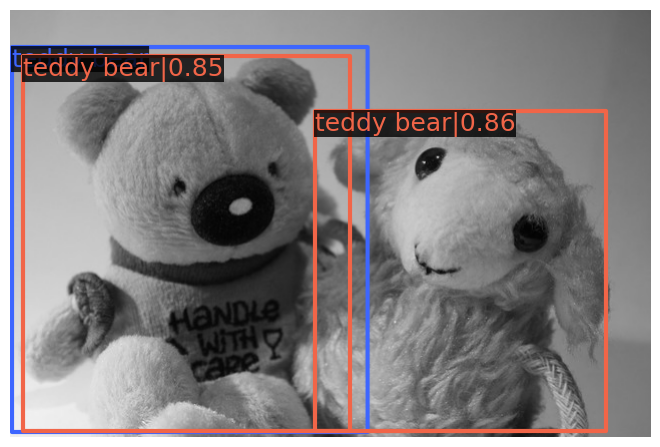

array([[[159, 159, 159],
        [159, 159, 159],
        [159, 159, 159],
        ...,
        [ 94,  94,  94],
        [ 94,  94,  94],
        [ 94,  94,  94]],

       [[160, 160, 160],
        [160, 160, 160],
        [160, 160, 160],
        ...,
        [ 94,  94,  94],
        [ 93,  93,  93],
        [ 92,  92,  92]],

       [[160, 160, 160],
        [160, 160, 160],
        [160, 160, 160],
        ...,
        [ 94,  94,  94],
        [ 93,  93,  93],
        [ 93,  93,  93]],

       ...,

       [[239, 238, 238],
        [240, 236, 236],
        [239, 227, 224],
        ...,
        [121, 121, 121],
        [121, 121, 121],
        [121, 121, 121]],

       [[239, 239, 239],
        [239, 239, 239],
        [239, 239, 239],
        ...,
        [121, 121, 121],
        [121, 121, 121],
        [121, 121, 121]],

       [[239, 239, 239],
        [239, 239, 239],
        [239, 239, 239],
        ...,
        [121, 121, 121],
        [121, 121, 121],
        [121, 121, 121]]

In [15]:
s_idx = np.random.randint(len(dataset))
data_info = dataset.prepare_train_img(s_idx)
dets = sub_results[s_idx]
imshow_gt_det_bboxes(
        data_info["img"], 
        data_info, 
        dets, 
        class_names=dataset.CLASSES, 
        thickness=3,
        font_size=18, 
        score_thr=0.)
